## **Import libraries**

In [ ]:
import os, sys, tarfile
import glob
from typing import List
from collections import Counter

import scipy.io
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import seaborn as sns
from skimage import io, transform
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support)

from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms as T, utils,models
import torch, torch.nn as nn
import torch.optim as optim
from torchsummary import summary

plt.ion()


if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"
device = torch.device(dev)
train_model=False


## **Download dataset**

link to dataset: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html



In [ ]:
# Download dataset to input folder
#  link for dataset documents: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

! wget --no-clobber https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz -P ./input/
! wget --no-clobber https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat -P ./input/
! wget --no-clobber  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat -P ./input/

base_addr = './input'
data_url = os.path.join(base_addr,"102flowers.tgz")
label_url = os.path.join(base_addr,"imagelabels.mat")
split_url = os.path.join(base_addr,"setid.mat")

base_drive = '/content/drive/MyDrive/ai/Roshan Internship/Image Retrieval'

--2022-09-04 19:36:49--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘./input/102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  97.4MB/s    in 3.4s    

2022-09-04 19:36:53 (96.3 MB/s) - ‘./input/102flowers.tgz’ saved [344862509/344862509]

--2022-09-04 19:36:53--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘./input/imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2022-09-04 19:36:53 (85.3 MB/s) - 

## **Functions**

In [ ]:
# Helper Functions
from scipy.sparse.csr import csr_count_blocks

def extract_tar(tar_url, extract_path='.'):
    '''
    extract tar format files into extract_path
    '''
    print (tar_url)
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract_tar(item.name, "./" + item.name[:item.name.rfind('/')])


def load_mat_to_np(mat_path,*keys,flatten=True,print_mat=False):
    data = scipy.io.loadmat(mat_path)
    if print_mat:
      print(f"mat file <{mat_path}> is {data}")
    if flatten is True:
      data_tups = [np.array(data[k]).flatten()-1 for k in keys]
    else:
      data_tups = [np.array(data[k])-1 for k in keys]
    return data_tups

def draw_list_diagram(numbers,title="title",xlabel="x",ylabel="y"):
    c = Counter(numbers)
    plt.bar(c.keys(), c.values())
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def show_images(images: List[np.ndarray]) -> None:
    """
    show multiple image in the plot
    """
    n: int = len(images)
    f = plt.figure()
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)

def dataframe_classes(data_frame,label_column:str="class"):
    """
    return list of unique entities in a list
    """
    classes=(data_frame[label_column].unique())
    classes.sort()

    return classes

def data_balance_train_split(data_frame,sample_per_class:int,label_column:str="class"):
    """
    Select balance number of samples for each class
    """
    classes = dataframe_classes(data_frame,label_column)

    min_n = np.min(classes)

    count_arr=np.zeros_like(classes)
    train_list=[]
    v_list=[]
    # print(data_frame.values)
    for p , l in data_frame.values:
        idx=l-min_n
        item=[p,l]
        if count_arr[idx] >= sample_per_class:
            v_list.append(item)
        else:
            train_list.append(item)
            count_arr[idx]+=1

    train_df=pd.DataFrame(train_list,columns=['path','class'])
    v_df = pd.DataFrame(v_list,columns=['path','class'])
    return train_df , v_df


# placeholder for model predicted batch features(pre-final layer output)
features = {}
def get_features(name='feats'):
    """
      HELPER FUNCTION FOR FEATURE EXTRACTION
    """
    def hook(model, input, output):
        features[name] = output
    return hook

def save_plots(train_acc, valid_acc, train_loss, valid_loss,base_dir=None):
    """
    Save the Loss and Accuracy plots to disk.
    """
    if base_dir is None:
      base_dir="/content"

    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(base_dir+'/outputs/accuracy_.png')

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(base_dir+'/outputs/loss_.png')

def same_pair(x):
    " if classes match will return 1 unless returns 0"
    # print("x is",x,"\ntf:",x.class1 == x.class2.astype(int))
    return (x.class1 != x.class2.astype(int)).astype(int)


def pair_data(frame1,frame2,label_column='class'):
    """
    creates a dataframe in form of (frame1.columns,frame2.columns,same)
    """

    count=min(len(frame1),len(frame2))
    # print("f1 len f2 len ",len(frame1),len(frame2))

    # for the two frame to be same size
    frame1 = frame1[0:count].copy()
    frame2 = frame2[0:count].copy()

    pair_f=pd.DataFrame(
        {
            "path1":frame1.path,
            "class1":frame1['class'],
            'path2':frame2.path,
            'class2':frame2['class'],

        },copy=True
    ).assign(same= same_pair)# are both images from same class or not

    # print("pair_f:\n",pair_f.head())

    m_frame = pair_f.loc[lambda df:df.same==0] # match class pair images
    um_frame = pair_f.loc[lambda df:df.same==1]

    return m_frame, um_frame


def shift_df(data_frame:pd.DataFrame,n:int =1):
    n = np.abs(n) % len(data_frame)

    slice_frame = data_frame[-n:].copy()

    s_df = data_frame.shift(periods=n)
    s_df[:n]=slice_frame[:]   # fill in first n blank rows

    return s_df



def create_pair_data_frame(data_frame:pd.DataFrame,n_pair:int,random_seed=0):
    """
    Create pair images for testing the image retrieval accuracy
    """
    label_column='class'
    classes = dataframe_classes(data_frame=data_frame, label_column=label_column)
    n_classes = len(classes)


    rand_df= data_frame.sample(frac=1,random_state=random_seed)
    rand_df_s= shift_df(rand_df,1)

    match_df, unmatch_df = pair_data(rand_df,rand_df_s)

    while len(match_df) < n_pair or len(unmatch_df)< n_pair:

        # shift the DF so create new pairs
        rand_df_s= shift_df(rand_df_s, 1)
        temp_match , temp_unmatch = pair_data(rand_df,rand_df_s,label_column=label_column)

        if len(match_df)< n_pair:
            match_df = pd.concat([temp_match,match_df])
            # match_df.append(temp_match)
            # print('len of matched df is',len(temp_match),'\nnew len',len(match_df))

        if len(unmatch_df) < n_pair:
            unmatch_df = pd.concat([temp_unmatch,unmatch_df])
            unmatch_df.append(temp_unmatch)
            # print('len of unmatched df is',len(temp_unmatch),'\nnew len',len(unmatch_df))



    print(f"Count of unmatched pairs are:{len(unmatch_df)} ,\nCount of unmatched pairs are:{len(match_df)}")

    return match_df , unmatch_df


### **Model helper function**

In [ ]:
# model Functions
def save_model( model, optimizer,center_opt, criterion,center_crit,suffix="base",base_dir=None):
    """
    Save the trained model parameters to disk.
    """
    if base_dir is None:
      base_dir='./input/models'


    torch.save({
                'epoch': suffix,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                "center_optimizer_dict": center_opt.state_dict(),
                'center_loss': center_crit.state_dict(),
                'loss': criterion,
                }, base_dir+f'/model_{suffix}.pth')


def load_model(model, center_crit,base_dir=None,suffix='base',device=dev):
  """
  Load model state from file
  """
  dic = torch.load(base_dir+f'/model_{suffix}.pth',map_location=device)
  model_state = dic["model_state_dict"]
  center_crit_state = (dic['center_loss'])
  # print (dic["model_state_dict"])
  return model_state, center_crit_state , dic['loss'],dic['optimizer_state_dict']

# training
def train(model, trainloader, optimizer,center_opt, criterion, center_criterion,weight_cent=1e-3):
    """
    Train model for one epoch on dataloder
    """
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    preds_list=[]
    labels_list=[]


    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.clone().squeeze().long().to(device)

        optimizer.zero_grad()
        center_opt.zero_grad()
        # forward pass
        outputs = model(image)

        feats = features['feats']
        # print("extracted feeatures:\n",feats.squeeze().shape,"\nlabels shape:",labels.squeeze().shape)
        # print("outputs shape",outputs.squeeze().shape)
        # calculate the loss
        class_loss= class_crit(outputs.squeeze(), labels)
        center_loss= center_crit(feats.squeeze(), labels)
        loss = class_loss + center_loss * weight_cent
        train_running_loss += loss.item()

        # calculate the accuracy
        preds = torch.argmax(outputs,dim=1)
        # print(f"preds for output {(outputs.data.squeeze()).shape} are {preds.shape} lables {labels.shape} \n"+'')
        # f"are {(preds == labels).shape}")
        train_running_correct += (preds == labels).sum().item()
        # backpropagation (calculate derivatives for parameters)
        loss.backward()
        # update the model parameters
        optimizer.step()

        # by doing so, weight_cent would not impact on the learning of centers
        for param in center_crit.parameters():
            param.grad.data*= (1. / weight_cent)

        center_opt.step()




    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# validation
def validate(model, testloader, criterion,center_crit,weight_crit=1e-3):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0


    preds_list=[]
    labels_list=[]
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.clone().to(device).squeeze().long()
            # labels = labels.view(-1,1)
            # forward pass
            outputs = model(image)
            feats = features['feats']

            # calculate the loss y_pred.squeeze()
            loss = criterion(outputs.squeeze(), labels)
            loss += weight_crit * center_crit(feats.squeeze(), labels)
            valid_running_loss += loss.item()

            # calculate the accuracy

            preds = torch.argmax(outputs,dim=1)
            # print(f"preds for output {(outputs.data.squeeze()).shape} are {preds.shape} lables {labels.shape} \n"+'')
            # f"are {(preds == labels).shape}")
            labels_list += (labels).tolist()
            preds_list += (preds).tolist()
            # print(preds.tolist())
            valid_running_correct += (preds == labels).sum().item()

    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc ,preds_list, labels_list


## **Dataset**

In [ ]:
# unzip dataset images
try:

    extract_tar(data_url,extract_path = base_addr)
    print ('Extracting images is Done.')
    img_path=os.path.join(base_addr,"jpg")
    print(f"img_path is {img_path}")
except:
    name = os.path.basename(sys.argv[0])
    print (name[:name.rfind('.')], ' <filename>')


# load lables dictionary from mat file
labels, = load_mat_to_np(label_url,"labels")
print("labels:",labels)

# load data split dictionary
train_ids,valid_ids,test_ids = load_mat_to_np(split_url,"trnid","valid","tstid",print_mat=True)
print(train_ids)


./input/102flowers.tgz
Extracting images is Done.
img_path is ./input/jpg
labels: [76 76 76 ... 61 61 61]
mat file <./input/setid.mat> is {'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009', '__version__': '1.0', '__globals__': [], 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16), 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16), 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}
[6764 6754 6767 ... 8025 8035 8040]


### **Visualize data distributions**

number of all images: (8189,),
labels: [76 76 76 ... 61 61 61]
3 most common classs [(50, 258), (76, 251), (45, 196), (72, 194), (88, 184), (73, 171), (80, 166), (93, 162), (87, 154)],
least common :[(6, 40), (44, 40), (33, 40), (26, 40), (20, 40), (0, 40), (2, 40), (38, 41), (78, 41)] 



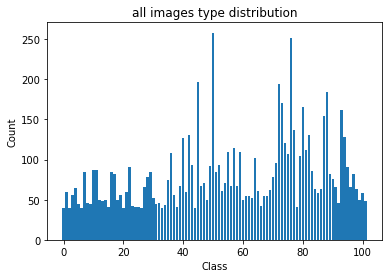

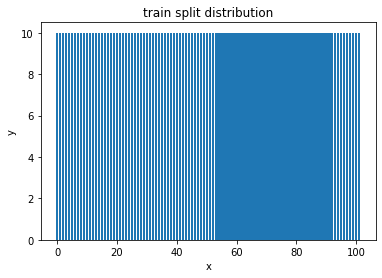

In [ ]:

label_count=Counter(labels)
print(f"number of all images: {labels.shape},\nlabels: {labels}\n"+
f"3 most common classs {label_count.most_common(n=9)},\nleast common :{label_count.most_common()[::-1][:9]} \n")

draw_list_diagram(labels,title="all images type distribution",xlabel="Class",ylabel="Count")
max_label = np.max(labels)
# print(np.max(labels))
draw_list_diagram(labels[train_ids],title='train split distribution')


### **load images path and create a dataframe**

In [ ]:
# load all images path
image_pattern = os.path.join(img_path,"*.jpg")
img_path_list = [f for f in glob.glob(image_pattern)]

# sort images to match the lables
img_path_list.sort()
print("images count:",len(img_path_list),"\n10 first images: ",img_path_list[:10])

# Create dataframe from image_path and labels
df = pd.DataFrame(list(zip(img_path_list, labels)),
               columns =['path', 'class'])
print("data frame head:\n",df.head(),"\n")


# select classes for test data
num_of_test_class = 12
num_of_train_class = 101 - num_of_test_class
most_c_labels = [l[0] for l in label_count.most_common()]

# split classes for unseen classes
test_split_class = df['class'].isin(np.array(range(max_label - num_of_test_class,max_label+1))) # select each row to be in the train set or not
test_class_df = df.loc[test_split_class] # Unseen classes for final test of retrieval task
train_class_df = df.loc[~ test_split_class]
print("test classes set len:",len(test_class_df),"\ntrain classes set len:",len(train_class_df),"\nnumber of train classes:",num_of_train_class)

# split validatioan train data
train_df, test_sample_df = data_balance_train_split(train_class_df,sample_per_class=34)

images count: 8189 
10 first images:  ['./input/jpg/image_00001.jpg', './input/jpg/image_00002.jpg', './input/jpg/image_00003.jpg', './input/jpg/image_00004.jpg', './input/jpg/image_00005.jpg', './input/jpg/image_00006.jpg', './input/jpg/image_00007.jpg', './input/jpg/image_00008.jpg', './input/jpg/image_00009.jpg', './input/jpg/image_00010.jpg']
data frame head:
                           path  class
0  ./input/jpg/image_00001.jpg     76
1  ./input/jpg/image_00002.jpg     76
2  ./input/jpg/image_00003.jpg     76
3  ./input/jpg/image_00004.jpg     76
4  ./input/jpg/image_00005.jpg     76 

test classes set len: 1017 
train classes set len: 7172 
number of train classes: 89


### **Create dataset customized class**

This class reads images from dataframe given path and returns the image and corrisponding label  after applying the transforms

In [ ]:
class classification_dataset(Dataset):

    def __init__(self, data_frame, transform=None,device=dev) -> None:
        """
        Args:
          data_frame (pandas.dataframe): Contains image path and respective labels.
          transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = data_frame
        self.transform = transform
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.df.iloc[idx, 0]
        image = io.imread(img_name)

        label = self.df.iloc[idx,1]
        label = np.array([label]).astype('float').reshape(-1,1)
        label = torch.tensor(label)

        if self.transform:
            image = self.transform(image)
        sample = (image,  label)


        return sample


In [ ]:
image_size=300
train_trans = T.Compose([
    T.ToPILImage(),
    T.Resize([image_size,image_size]),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Imagenet Dataset mean and std

])

test_trans = train_trans
train_images = classification_dataset(data_frame=train_df,transform = train_trans)
print("dataset length",len(train_images))
print("images 1",train_images[1][0].shape,",Image device",train_images[1][0].device)
train_loader=DataLoader(train_images,shuffle=True,batch_size=20)

test_images = classification_dataset(data_frame=test_sample_df,transform = test_trans)

test_loader = DataLoader(test_images,batch_size=30)



dataset length 3026
images 1 torch.Size([3, 300, 300]) ,Image device cpu


## Define fature extractor model

In [ ]:
# Use pretrained resnet18 model
model=models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(dev)

model.fc = torch.nn.Linear(in_features=512,out_features=num_of_train_class,device=dev)
print(model)
h=model.avgpool.register_forward_hook(get_features('feats'))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Center Loss
Link for Center loss complete implementation: https://github.com/KaiyangZhou/pytorch-center-loss

In [ ]:
torch.manual_seed(0)
class CenterLoss(nn.Module):
    """Center loss.

    Reference:
    1.Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    2.Understanding Center Loss Based Network for Image Retrieval with Few Training Data. ECCV 2018.


    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, device='cpu'):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device

        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim,device=self.device),requires_grad=True)
        print(self.centers.shape)
        print(self.parameters())


    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        classes = classes.to(self.device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

## Optimizers and criterion

In [ ]:
num_of_iter=11
center_lr = 0.001
lr=0.0002
center_loss_weight = 1e-3

center_crit = CenterLoss(num_classes=num_of_train_class, feat_dim=model.fc.in_features, device=dev)
class_crit = nn.CrossEntropyLoss()
print(list(center_crit.parameters()))
center_opt = torch.optim.Adam(center_crit.parameters(),lr=center_lr)
class_opt = torch.optim.Adam(model.parameters(),lr=lr)

# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

torch.Size([89, 512])
<generator object Module.parameters at 0x7f0430c0a750>
[Parameter containing:
tensor([[-1.1258e+00, -1.1524e+00, -2.5058e-01,  ..., -1.6989e+00,
          1.3094e+00, -1.6613e+00],
        [-5.4607e-01, -6.3018e-01, -6.3465e-01,  ...,  5.3743e-01,
          1.0826e+00, -1.7105e+00],
        [-1.0841e+00, -1.2874e-01, -6.8108e-01,  ..., -3.6313e-02,
          9.8121e-02,  9.6356e-01],
        ...,
        [-5.9708e-01, -9.9659e-01,  1.5495e+00,  ...,  2.3496e+00,
          1.3477e-01,  1.7267e+00],
        [-1.2970e+00, -9.9760e-01,  7.5718e-01,  ..., -6.2570e-01,
         -9.2162e-01,  2.8878e-01],
        [-2.5901e-01,  1.2004e-01,  2.3223e+00,  ...,  8.5549e-04,
          2.7968e-01,  1.8968e+00]], requires_grad=True)]


## Train classifier model

In [ ]:
if train_model:
  for epoch in range(num_of_iter):

      print("==> Epoch {}/{}".format(epoch+1, num_of_iter))
      train_epoch_loss, train_epoch_acc=train(model=model,trainloader=train_loader, criterion=class_crit,
            center_criterion=center_crit, optimizer=class_opt, center_opt=center_opt,
            weight_cent=center_loss_weight
            )

      (valid_epoch_loss, valid_epoch_acc,
      preds_list, labels_list) = validate(model, test_loader, class_crit,center_crit=center_crit,
                                            weight_crit=center_loss_weight)

      # Saving loss and accuracy of model on data
      train_loss.append(train_epoch_loss)
      valid_loss.append(valid_epoch_loss)
      train_acc.append(train_epoch_acc)
      valid_acc.append(valid_epoch_acc)
      prec, rec, f1,_ =precision_recall_fscore_support(labels_list,preds_list)
      print(f"Training loss: {train_epoch_loss:.6f}, training acc: {train_epoch_acc:.6f}")
      print(f"Validation loss: {valid_epoch_loss:.6f}, validation acc: {valid_epoch_acc:.6f},")



==> Epoch 1/11
Training


  0%|          | 0/152 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)


Validation


  0%|          | 0/139 [00:00<?, ?it/s]

Training loss: 0.792440, training acc: 99.768672
Validation loss: 1.011346, validation acc: 91.944042,
==> Epoch 2/11
Training


  0%|          | 0/152 [00:00<?, ?it/s]

Validation


  0%|          | 0/139 [00:00<?, ?it/s]

Training loss: 0.585489, training acc: 99.537343
Validation loss: 1.046858, validation acc: 88.712012,
==> Epoch 3/11
Training


  0%|          | 0/152 [00:00<?, ?it/s]

Validation


  0%|          | 0/139 [00:00<?, ?it/s]

Training loss: 0.500726, training acc: 99.537343
Validation loss: 1.039696, validation acc: 86.806561,
==> Epoch 4/11
Training


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/152 [00:00<?, ?it/s]

Validation


  0%|          | 0/139 [00:00<?, ?it/s]

Training loss: 0.376206, training acc: 99.801718
Validation loss: 0.644930, validation acc: 93.873613,
==> Epoch 5/11
Training


  0%|          | 0/152 [00:00<?, ?it/s]

Validation


  0%|          | 0/139 [00:00<?, ?it/s]

Training loss: 0.407680, training acc: 98.777264
Validation loss: 0.772900, validation acc: 90.738061,
==> Epoch 6/11
Training


  0%|          | 0/152 [00:00<?, ?it/s]

Validation


  0%|          | 0/139 [00:00<?, ?it/s]

Training loss: 0.282323, training acc: 99.900859
Validation loss: 0.561398, validation acc: 93.801254,
==> Epoch 7/11
Training


  0%|          | 0/152 [00:00<?, ?it/s]

Validation


  0%|          | 0/139 [00:00<?, ?it/s]

Training loss: 0.216134, training acc: 100.000000
Validation loss: 0.520811, validation acc: 93.921852,
==> Epoch 8/11
Training


  0%|          | 0/152 [00:00<?, ?it/s]

Validation


  0%|          | 0/139 [00:00<?, ?it/s]

Training loss: 0.185262, training acc: 100.000000
Validation loss: 0.493753, validation acc: 94.259527,
==> Epoch 9/11
Training


  0%|          | 0/152 [00:00<?, ?it/s]

Validation


  0%|          | 0/139 [00:00<?, ?it/s]

Training loss: 0.162018, training acc: 100.000000
Validation loss: 0.463867, validation acc: 94.693681,
==> Epoch 10/11
Training


  0%|          | 0/152 [00:00<?, ?it/s]

Validation


  0%|          | 0/139 [00:00<?, ?it/s]

Training loss: 0.141815, training acc: 100.000000
Validation loss: 0.441416, validation acc: 94.741920,
==> Epoch 11/11
Training


  0%|          | 0/152 [00:00<?, ?it/s]

In [ ]:
(valid_epoch_loss, valid_epoch_acc,
     preds_list, labels_list) = validate(model, test_loader, class_crit,center_crit=center_crit,
                                          weight_crit=center_loss_weight)


Validation


  0%|          | 0/139 [00:00<?, ?it/s]

### saving trained classifier for subsequent uses

In [ ]:
save_model(model = model, optimizer=class_opt, center_opt=center_opt, center_crit=center_crit, criterion=class_crit,
           base_dir=base_drive, suffix=f"{num_of_iter}_{int(train_epoch_acc)}_{int(valid_epoch_acc)}")

# save and show learning diagrams
save_plots(train_acc=train_acc,valid_acc=valid_acc
           ,train_loss=train_loss,valid_loss=valid_loss)

## Create pair dataset

In [ ]:
tc_match_df,tc_unmatch_df=create_pair_data_frame(test_class_df,12000) # unseen classes pairs
tc_df=pd.concat([tc_match_df,tc_unmatch_df],ignore_index=True)
ts_match_df,ts_unmatch_df=create_pair_data_frame(test_sample_df,32000) # unseen samples from classifier classes
ts_df=pd.concat([ts_unmatch_df,ts_match_df],ignore_index=True)

Count of unmatched pairs are:12079 ,
Count of unmatched pairs are:12022
Count of unmatched pairs are:32394 ,
Count of unmatched pairs are:32020


In [ ]:
tc_df.head()

,path1,class1,path2,class2,same
0,./input/jpg/image_07935.jpg,99,./input/jpg/image_07909.jpg,99.0,0
1,./input/jpg/image_06046.jpg,92,./input/jpg/image_06024.jpg,92.0,0
2,./input/jpg/image_03043.jpg,91,./input/jpg/image_03076.jpg,91.0,0
3,./input/jpg/image_07609.jpg,95,./input/jpg/image_07613.jpg,95.0,0
4,./input/jpg/image_07315.jpg,93,./input/jpg/image_07339.jpg,93.0,0


### create pairs custom dataset

In [ ]:
class pair_dataset(Dataset):
    def __init__(self, data_frame, transform=None,device=dev) -> None:
        """
        Args:
          data_frame (pandas.dataframe): Contains image path and respective labels.
          transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = data_frame
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img1_name = self.df.iloc[idx, 0]
        image1 = io.imread(img1_name)

        img2_name = self.df.iloc[idx, 2]
        image2 = io.imread(img2_name)

        label = self.df.iloc[idx,4]
        label = np.array([label]).astype('float').reshape(-1,1)
        label = torch.tensor(label)

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        sample = (image1, image2,  label)


        return sample

### Create data loader

In [ ]:
class_ds=pair_dataset(tc_df,train_trans)
sample_ds=pair_dataset(ts_df,train_trans)
class_pdl=DataLoader(class_ds,batch_size=50,drop_last=True) # unseen class pair data loader
sample_pdl=DataLoader(sample_ds,batch_size=50,drop_last=True) # unseen sample pair data loader

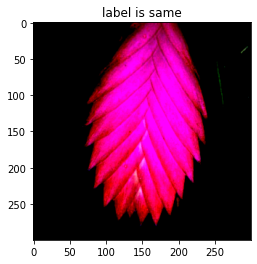

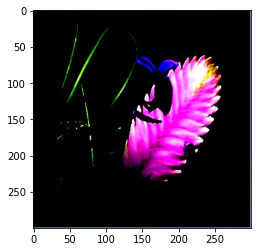

In [ ]:
idx=2002
img1,img2,lb=class_ds[idx]
title = "same" if 0==lb.item() else 'not same'
plt.figure()
plt.title(f"label is {title}")
plt.imshow(img1.permute(1, 2, 0))
plt.figure()
plt.imshow(img2.permute(1, 2, 0))

### load trained model

In [ ]:
# load trained classifier model
model_suffix = '11_100_94'

(model_state, l_center_crit,l_class_crit, optimizer_dic)=load_model(model,center_crit=center_crit,
                                                                     base_dir=base_drive,suffix=model_suffix,device=dev)
ml=model.load_state_dict(model_state)
print(ml)
# uncomment to see model summary
summary(model,(3,300,300),batch_size=20)


<All keys matched successfully>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [20, 64, 150, 150]           9,408
       BatchNorm2d-2         [20, 64, 150, 150]             128
              ReLU-3         [20, 64, 150, 150]               0
         MaxPool2d-4           [20, 64, 75, 75]               0
            Conv2d-5           [20, 64, 75, 75]          36,864
       BatchNorm2d-6           [20, 64, 75, 75]             128
              ReLU-7           [20, 64, 75, 75]               0
            Conv2d-8           [20, 64, 75, 75]          36,864
       BatchNorm2d-9           [20, 64, 75, 75]             128
             ReLU-10           [20, 64, 75, 75]               0
       BasicBlock-11           [20, 64, 75, 75]               0
           Conv2d-12           [20, 64, 75, 75]          36,864
      BatchNorm2d-13           [20, 64, 75, 75]             128
       

### helper function for testing pair detection accuracy

In [ ]:
def test_pair_retrieval(data_loader,model,dis_method,threshold=0.5,device=device):
    """
    predict the two paired images have same class or not respective to the threshold

    args:
      data_loader: data_loade
    """
    model.eval()
    print('Test')
    valid_running_correct = 0
    counter = 0


    preds_list=[]
    labels_list=[]
    diff_list=[]
    with torch.no_grad():
        for i, data in tqdm(enumerate(data_loader), total=len(data_loader)):
            counter += 1

            image1,image2, labels = data
            image1 = image1.to(device)
            image2 = image2.to(device)
            labels = labels.clone().to(device).squeeze().long()
            # labels = labels.view(-1,1)

            # Extract features for images
            outputs1 = model(image1)
            feats1 = features['feats']

            outputs2 = model(image2)
            feats2 = features['feats']

            # calculate the differnce of features
            diff = dis_method(feats1,feats2)

            diff0 = diff - threshold
            values = torch.tensor([0.],device=device)
            preds = torch.heaviside(diff0, values)


            # print(f"preds for output {(outputs.data.squeeze()).shape} are {preds.shape} lables {labels.shape} \n"+'')
            diff_list += diff.tolist()
            labels_list += (labels).tolist()
            preds_list += (preds).tolist()
            # print("Predictions list for batch\n",preds.squeeze()," , label shape:",labels,' , vc shape',diff.squeeze())
            valid_running_correct += (preds.squeeze() == labels).sum().item()

    # loss and accuracy for the complete epoch
    epoch_acc = 100. * (valid_running_correct / len(data_loader.dataset))
    return  epoch_acc ,preds_list, labels_list, diff_list

def consine_dis(t1,t2):
    return nn.functional.cosine_similarity(t1, t2)

def euclidean_dis(t1,t2):
    assert (t1.shape[0]==t2.shape[0]) , 'both tensors must have the same batch size'
    batch_size=t1.shape[0]
    dis=torch.sum(((t2 - t1)**2).reshape(batch_size,-1),dim=1)
    return dis


## **Test pair prediction**

In [ ]:
#class_pdl ,sample_pdl
dis_method=consine_dis

(c_epoch_acc ,c_preds_list, c_labels_list,
 c_diff_list) = test_pair_retrieval(data_loader= class_pdl,model= model, dis_method=dis_method,device=device )

print(f'accuracy for unseen samples from test classes is {c_epoch_acc:.6f} for thereshold 0.5 and using distance method {dis_method}')


s_epoch_acc=0.00
(s_epoch_acc ,s_preds_list, s_labels_list,
 s_diff_list) = test_pair_retrieval(data_loader= sample_pdl,model= model, dis_method=dis_method,device=device )

print(f'accuracy for unseen samples from traning classes is {s_epoch_acc:.6f} for thereshold 0.5 and using distance method {dis_method}')




Test


  0%|          | 0/482 [00:00<?, ?it/s]

accuracy for unseen samples from test classes is 50.022821 for thereshold 0.5 and using distance method <function consine_dis at 0x7fac807a3e60>
Test


  0%|          | 0/1288 [00:00<?, ?it/s]

accuracy for unseen samples from traning classes is 12.315646 for thereshold 0.5 and using distance method <function consine_dis at 0x7fac807a3e60>


In [ ]:
print(f'accuracy for unseen samples from test classes is {c_epoch_acc:.6f} for thereshold 0.5 and using distance method {dis_method}')


accuracy for unseen samples from test classes is 47.093482 for thereshold 0.5 and using distance method <function consine_dis at 0x7face164cc20>
